# Abstract

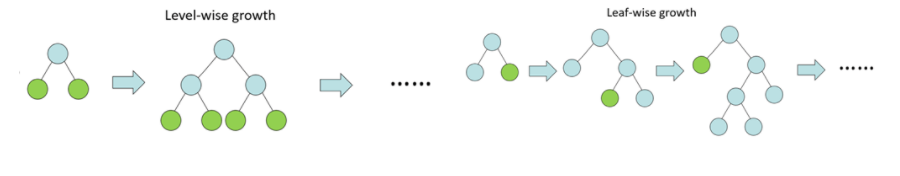

#### Light GBM's GBM is a Gradient Boosting Model, a tree-based learning algorithm. To put it simply, 
#### the learning method of this GBM can be said to proceed while adding weight to the wrong part.

#### In Gradient Boosting, boosting is a concept that makes several trees, develops the existing model
#### little by little and adds them at the end, which is different from the random forest bagging technique.

**There are two main ways of boosting.**

#### 1. A method of giving weight to important data (generally data with incorrect model) such as AdaBoost

#### 2. A method of repeatedly training the difference between correct answers and incorrect answers like a loss function like GBDT

In [ ]:
#all will be used.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import seaborn as sns
import sys
import csv
import datetime
import operator
import joblib
import warnings

from sklearn.model_selection import train_test_split

# Load Data

In [ ]:
train = pd.read_csv("../input/tabular-playground-series-nov-2021/train.csv")
test = pd.read_csv("../input/tabular-playground-series-nov-2021/test.csv")

In [ ]:
#NULL does not exist. good!

train.isnull().sum()[train.isnull().sum() != 0]

In [ ]:
#Remove meaningless features.

train_df = train.drop(['id'], axis = 1 )
test_df = test.drop(['id'], axis = 1)

# Light GBM Modeling

In [ ]:
# data segmentation
X = train_df.drop('target', axis=1)
y = train_df['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0) # train, valid 8:2 분할

**Find the best parameters**

In [ ]:
params = {'device_type': 'gpu',
        'n_estimators': 10000,
        'learning_rate': 0.2423075935828885,
        'num_leaves': 2260,
        'max_depth': 9,
        'min_data_in_leaf': 8600,
        'lambda_l1': 70,
        'lambda_l2': 35,
        'min_gain_to_split': 0.11775633820897208,
        'bagging_fraction': 0.6000000000000001,
        'bagging_freq': 1,
        'feature_fraction': 0.6000000000000001,}

In [ ]:
lgbm_clf = LGBMClassifier(**params)

In [ ]:
start = datetime.datetime.now()
lgbm = lgbm_clf.fit(X_train,
                       y_train,
                       eval_set = [(X_train, y_train), (X_valid, y_valid)], 
                       eval_metric = 'auc',
                       early_stopping_rounds = 15,
                       verbose = True)
end = datetime.datetime.now()
end-start

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [ ]:
y_pred = lgbm_clf.predict(X_valid)

In [ ]:
def classifier_eval(y_valid , y_pred) :
  print('정확도(accuracy_score) : ', accuracy_score(y_valid, y_pred))
  print('정밀도(precision_score) : ', precision_score(y_valid, y_pred))
  print('재현율(recall_score) : ', recall_score(y_valid, y_pred))
  print('F1 : ', f1_score(y_valid, y_pred))
  print('AUC : ', roc_auc_score(y_valid, y_pred))

classifier_eval(y_valid, y_pred)

In [ ]:
x = np.array([accuracy_score(y_valid, y_pred),
              precision_score(y_valid, y_pred),
              recall_score(y_valid, y_pred),
              f1_score(y_valid, y_pred),
              roc_auc_score(y_valid, y_pred)])

x

In [ ]:
label = ['accuracy', 'precision', 'recall_score', 'f1_score', 'roc_auc']

index = np.arange(len(label))


plt.bar(index, x, width=0.5)
plt.title('evaluation index', fontsize=20)
plt.ylabel('%', fontsize=18)
plt.xticks(index, label, fontsize=15,rotation=90)    # X축의 범위: [xmin, xmax]
plt.ylim([0, 1])     # Y축의 범위: [ymin, ymax]
plt.show()

# Submission

In [ ]:
lightGBM_prediction = lgbm_clf.predict(test_df)

In [ ]:
submission_lightGBM = pd.DataFrame({'id':test['id'], 'target':lightGBM_prediction})
submission_lightGBM.head()

In [ ]:
submission_lightGBM.to_csv('./submission.csv', index=False)